# Implementation of Using Convolution Filters with clustering techniques (DBSCAN) and Understanding of CNN via layer wise relevance propagation (or similar techniques) 

In [1]:
%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


### Definitions

In [2]:
def standard(x,height,decay):
    y = height*np.exp(-x*decay)
    return y

def shifter(x,starts):
    L = int(starts*len(x))
    y = np.zeros(len(x))
    y[:L] = np.zeros(L) 
    y[L:] = x[:(len(x)-L)]
    return y

def comb_standard(x,second,height_1,decay_1,height_2,decay_2):
    L = int(second*len(x))
    y = np.zeros(len(x))
    y[:L] = standard(x[:L],height_1,decay_1)
    y[L:] = standard(x[:(len(x)-L)],height_2,decay_2)
    return y

def noiser(x,strength):
    y = x + np.random.normal(0,strength,len(x))
    return y

def noiser_long(x,strength):
    noise = np.random.normal(0,strength,len(x))
    y = x + np.cumsum(noise)*strength
    return y

def noiser_comb(x,sepfact,strength):
    L = int(sepfact*len(x))
    x[:L] = noiser(x[:L],strength)
    x[L:] = noiser_long(x[L:],strength)
    return x

def array_maker(entries):
    x = np.arange(0,1,1/4096)
    x = np.expand_dims(x,axis=0)
    x = np.tile(x,[entries,1])
    return x

def double(x,second,height_1,decay_1,height_2,decay_2,starts,sepfact=0.15,strength=0.02):
    y = comb_standard(x,second,height_1,decay_1,height_2,decay_2)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def single(x,height,decay,starts,sepfact=0.15,strength=0.02):
    y = standard(x,height,decay)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def event_creators_single(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(5,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_2(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(10,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_3(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.1)
        r = np.random.normal(4,1)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_sharp(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(100,20)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)    
    return x

def event_creators_double_equal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.01)
        q = np.random.normal(5,2)
        r = np.random.normal(1,0.01)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x
    
def event_creators_double_unequal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.2)
        q = np.random.normal(50,10)
        r = np.random.normal(1,0.2)
        s = np.random.normal(50,10)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

def event_creators_sharp_fat(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.015,0.001)
        p = np.random.normal(1,0.2)
        q = np.random.normal(100,20)
        r = np.random.normal(0.2,0.05)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3

def reader_pmtall(path):
    extra = np.arange(4096, 4480)
    tree = uproot.open(path)["tree"]
    pmtall = tree.array("PMTALL")
    pmtall = np.delete(pmtall, extra, axis=1)
    return pmtall

def reader(path,branch,number):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    column = column[:,number]
    return column

def reader_lone(path,branch):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    return column

def pmtall_pedestal(path):
    pedestal = reader(path,"Pedestal",0)
    pmtall = reader_pmtall(path)
    for i in range(len(pedestal)):
        pmtall[i] = -(pmtall[i]-pedestal[i])
    
    return pmtall

In [3]:
def comb(one,two,three,four,five,six,seven,eight,nine,ten,portion):
    one1,one2 = sep(one,1,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,1,portion)
    four1,four2 = sep(four,1,portion)
    five1,five2 = sep(five,1,portion)
    six1,six2 = sep(six,0,portion)
    seven1,seven2 = sep(seven,0,portion)
    eight1,eight2 = sep(eight,0,portion)
    nine1,nine2 = sep(nine,0,portion)
    ten1,ten2 = sep(ten,0,portion)

    z = np.concatenate((one1,two1,three1,four1,five1,six1,seven1,eight1,nine1,ten1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2,six2,seven2,eight2,nine2,ten2),axis=0)
    return z, y

# Load data
build it using python class

In [2]:
%time
class Waveform():
    
    def __init__(self, path=None, no_classes=None):
        if path is None:
            raise ValueError("Insert file path!")
        if no_classes is None:
            raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = -(pmtall[i]-pedestal_sum[i])
#         number = 
        
        # random labelling(test purposes)
        self.waveform = pmtall
        self.label = np.random.randint(3,size=(len(pmtall),))
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return (self.waveform[idx],self.label[idx])


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [3]:
no_classes = 3
dataset = Waveform(path="Run009-069-001.root", no_classes=no_classes)

In [4]:
BATCH_SIZE = 1000
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=3) 

# #Testing#
# for i in dataset:
#     print(len(i[0]),len(i[1]))
# for i in data_loader:
#     print(i[0].size())
#     print(i[1].size())
# print(len(dataset))


In [5]:
print(len(dataset))
n_batches = int(len(dataset)/BATCH_SIZE) -1

41260


In [6]:
n_batches

40

# Define CNN structure
using an autoencoder for self-training, taking encoder part or decoder part for features learning

In [2]:
print(torch.randn(10,10).size())

torch.Size([10, 10])


In [7]:
# BATCH_SIZE=2000

from torch import nn
from torch.autograd import Variable

# Discriminator
class Classifier(nn.Module):
    def __init__(self, input_chn, no_classes, kernel_size, 
                 no_filters, padding, maxpool, batch_size):
        super(Classifier, self).__init__()
        self.input_chn = input_chn
        self.no_classes = no_classes
        self.kernel_size = kernel_size
        self.padding = padding
        self.no_filters = no_filters
        self.maxpool = maxpool
        self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(input_chn)
        self.c1 = nn.Conv1d(input_chn ,no_filters ,kernel_size ,padding=padding )
        self.p1 = nn.MaxPool1d(maxpool ,padding )
        self.lr = nn.LeakyReLU(0.2)
        self.c2 = nn.Conv1d(no_filters, int(no_filters/2), kernel_size, padding=padding)
        self.p2 = nn.MaxPool1d(maxpool ,padding )       
        self.l1 = nn.Linear(4096,64)
        self.h1 = nn.Linear(64,64)
        self.out = nn.Linear(64, no_classes)  
        self.sg = nn.Sigmoid()
        
    def forward(self, inputs):
        
#         x = inputs.view(self.batch_size,1,-1)
#         x = self.norm(x)
        x = self.c1(x)
        x = self.lr(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.lr(x)
        x = self.p2(x)
        
        x = x.view(self.batch_size,-1)
        
        x = self.l1(x)
        x = self.lr(x)
        x = self.h1(x)
        x = self.out(x)
        outputs = self.sg(x)
        return outputs
    
# Autoencoder
# WIP!
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,batch_size):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
        self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1,32,8,4,padding=1)
        self.pl1 = nn.MaxPool1d(2,4)
        self.cv21 = nn.Conv1d(32,16,8,4,padding=1)
        self.pl21 = nn.MaxPool1d(2,4)
        self.cv22 = nn.Conv1d(32,16,8,4,padding=1)
        self.pl22 = nn.MaxPool1d(2,4)

        self.ct1 = nn.ConvTranspose1d(16,32,8,8)
        self.ct2 = nn.ConvTranspose1d(32,64,10,8,padding=1)
        self.ct3 = nn.ConvTranspose1d(64,1,6,4,padding=1)
        
    def encoder(self, x):
        h0 = self.norm(x)
        h1 = F.relu(self.pl1(self.cv1(h0)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.relu(self.ct1(z))
        h3 = F.relu(self.ct2(h3))
        return F.sigmoid(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
        

# CNN = Classifier(1, no_classes=3, kernel_size=8, no_filters=32, 
#                  padding=4, maxpool=2, batch_size=BATCH_SIZE) 

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

# print(CNN)
# for parameter in CNN.parameters():
#     print(parameter.size())

print("Autoencoder")

GEN = Autoencoder(BATCH_SIZE)
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(1,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 16, kernel_size=(8,), stride=(4,), padding=(1,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 16, kernel_size=(8,), stride=(4,), padding=(1,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(16, 32, kernel_size=(8,), stride=(8,))
  (ct2): ConvTranspose1d(32, 64, kernel_size=(10,), stride=(8,), padding=(1,))
  (ct3): ConvTranspose1d(64, 1, kernel_size=(6,), stride=(4,), padding=(1,))
)
torch.Size([1])
torch.Size([1])
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([16, 32, 8])
torch.Size([16])
torch.Size([16, 32, 8])
torch.Size([16])
torch.Size([16, 32, 8])
torch.Size([32])
torch.S

In [8]:
    
print("#DUMMY WORKSPACE")    

from sklearn.cluster import DBSCAN
print(data_loader)

# TEST = CNN(Variable(torch.randn(BATCH_SIZE,1,4096)))
TEST = GEN.encoder(Variable(torch.randn(BATCH_SIZE,1,4096)))
DATA = TEST[0].reshape(BATCH_SIZE,1,-1)
print(TEST[0].size())
print(TEST[1].size())

print(DATA.size())
# print(TEST[2].size())
# print(TEST[0].detach().numpy())


# print("DBSCAN")
# db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
# print(db.core_sample_indices_)
# print(db.labels_)

#DUMMY WORKSPACE
torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])
torch.Size([1000, 1, 256])


# training
transform to Torch.Variable

In [8]:
from torch.autograd import Variable

def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

# Dummy code workspace

In [50]:
output = Variable(torch.randn(10,120))
target = Variable(torch.FloatTensor(10).uniform_(0, 120).long())
print(torch.FloatTensor(10))
print(torch.FloatTensor(10).uniform_(0,1).long())
# print(output,target)

loss = criterion(output,target)
print(loss)

RuntimeError: Overflow when unpacking long

In [9]:
N_EPOCHS = 2



# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        for batch_number, (waveform,label) in enumerate(data_loader):
            
#             print("epoch=",epoch)
#             print(batch_number)
#             print(waveform.size(),label.size())
    
            batch_size = waveform.size()[0]
            training_data = to_var(waveform.view(batch_size,1,4096))
            target = training_data
            
#             print(training_data,target)
            
            outputs = GEN(training_data)
#             print(outputs, target.view(-1).long())
            
#             print(outputs[0].size())
#             print(training_data.size())
            loss = criterion(outputs[0], target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


#             print(loss.data[0])
        
            if (batch_number +1)%2 == 0:
                print("Epoch[%d/%d], Step[%d/%d], loss=%.4f, Mean Discriminator output=BLANK.4f"
                      %(epoch,
                        N_EPOCHS,
                        batch_number+1,
                        n_batches,
                        loss.data[0] ))
            
#             print(GEN.state_dict())
            torch.save(GEN.state_dict(), "GEN_%d%d.pkl"%(epoch,N_EPOCHS))
            print(GEN.encoder(training_data)[0].size())

except KeyboardInterrupt:
    print('Training ended early.')



torch.Size([1000, 16, 16])


/home/danny/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[0/2], Step[2/40], loss=12.8684, Mean Discriminator output=BLANK.4f
torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])
Epoch[0/2], Step[4/40], loss=12.1236, Mean Discriminator output=BLANK.4f
torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])
Epoch[0/2], Step[6/40], loss=11.9357, Mean Discriminator output=BLANK.4f
torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])
Epoch[0/2], Step[8/40], loss=12.3148, Mean Discriminator output=BLANK.4f
torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])
Epoch[0/2], Step[10/40], loss=11.7095, Mean Discriminator output=BLANK.4f
torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])
Epoch[0/2], Step[12/40], loss=15.2681, Mean Discriminator output=BLANK.4f
torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])
Epoch[0/2], Step[14/40], loss=12.3177, Mean Discriminator output=BLANK.4f
torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])
Epoch[0/2], Step[16/40], loss=12.6584, Mean Discriminator output=BLANK.4f
torch.Size([1000, 16, 16])
torch.S

# Testing output of models

In [10]:
Features = torch.randn(41260,16,16)
print(Features[:1000].size())

torch.Size([1000, 16, 16])


In [11]:
try:
    for batch_number, (waveform,label) in enumerate(data_loader):

        print(batch_number,label.size())
        print(waveform.size())

        batch_size = waveform.size()[0]
        print(batch_size)
        feat = GEN.encoder(to_var(waveform.view(batch_size,1,4096)))
        print(feat[0].size())
        Features[batch_number*1000:(batch_number+1)*1000] = feat[0]

        print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)

except KeyboardInterrupt:
    print('Training ended early.')
## PLOT the test results



0 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
1 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
2 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
3 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
4 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
5 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
6 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
7 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
8 torch.Size([1000])
torch.Size([1000, 4096])
1000
torch.Size([1000, 16, 16])
torch.Size([41260, 16, 16])
9 torch.Size([1000])
torch.Size([1000, 4096])


In [12]:
generated = Features.view(-1,256)
print(generated.size())

torch.Size([41260, 256])


In [19]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=20).fit(generated[:10000].detach().numpy())
print(db.core_sample_indices_)
print(db.labels_)

/home/danny/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/danny/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


[   0    1    2 ... 9997 9998 9999]
[0 0 0 ... 0 0 0]


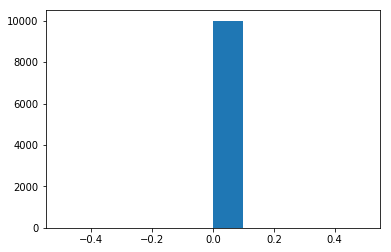

In [20]:
plt.hist(db.labels_)
plt.show()

# extracting filters/features

Use the protion of the Autoencoder transfer the trained weight to semi-half model of autoencoder.
Uses the output of the midlle layer of autoencoder and do a clustering on it.

The cluster number is a single vector(multi-class in keras?) representing the "output" of the group class.

# How to let this last layer of output automatically deduce itself.?
* save every sample output? how to make gives a supervised like methods output??

#Retrain the network but freeze all layer except for the last layer (clustering analysis layer). this can uses for LWRP studies, identify physical meaning of grouping. with it?

* understanding Neural Network, how to get layer-wise relevance propagation work for the last layer?

# Clustering techniques
most likely DBSCAN don't require to specify number of clusters however this can explode making difficult to use, the best option for now

# Layer Wise Relevance Propagation Or similiar techniques
The purpose of understanding CNN, see which portion of data gives more importance, mostly likely create a new CNN using trained weights from autoencoder with the final layers self-created based of the results of clustering. This can allow us to treate this CNN as supervised technique like however in reality as it is based on purely unsupervised techniques. This supervised like technique allows us to use technique like layer wise relevance propagation to understand the CNN giving us insight of the working of features learned by the cNN.